In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ipldata/deliveries.csv
/kaggle/input/ipldata/matches.csv


#### The CRISP-DM method will be applied here to keep track of the analysis process. I learned this method from the Udacity Nanodegree Datascientist Program. 

## 1. Business Understanding

I am a cricket player since my childhood - hence exploring this dataset is an immense fun which might help me to get to know some exciting insights on this game.

I will focus on the bewlow question below:

Q1: What is the win percentage of a team batting second at Wankhede Stadium during 2008 to 2019? 

Q2: Which are the weekdays Kolkata Knight Riders wins the most?

Q3: Which is the best IPL team and how many times it had won in the past?  

Q4: Predict the winner of the match by just using the matches dataset fields? - This is a classic binary classification problem


Let us first import the necessary modules.!



### Load packages

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

### 2.Data Understanding

In [3]:
deliveries_df = pd.read_csv('/kaggle/input/ipldata/deliveries.csv')

In [4]:
deliveries_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [5]:
matches_df = pd.read_csv('/kaggle/input/ipldata/matches.csv')

In [6]:
matches_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [7]:
matches_df.describe()

,id,season,dl_applied,win_by_runs,win_by_wickets
count,756.000000,756.000000,756.000000,756.000000,756.000000
mean,1792.178571,2013.444444,0.025132,13.283069,3.350529
std,3464.478148,3.366895,0.156630,23.471144,3.387963
min,1.000000,2008.000000,0.000000,0.000000,0.000000
25%,189.750000,2011.000000,0.000000,0.000000,0.000000
50%,378.500000,2013.000000,0.000000,0.000000,4.000000
75%,567.250000,2016.000000,0.000000,19.000000,6.000000
max,11415.000000,2019.000000,1.000000,146.000000,10.000000


In [8]:
matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 18 columns):
id                 756 non-null int64
season             756 non-null int64
city               749 non-null object
date               756 non-null object
team1              756 non-null object
team2              756 non-null object
toss_winner        756 non-null object
toss_decision      756 non-null object
result             756 non-null object
dl_applied         756 non-null int64
winner             752 non-null object
win_by_runs        756 non-null int64
win_by_wickets     756 non-null int64
player_of_match    752 non-null object
venue              756 non-null object
umpire1            754 non-null object
umpire2            754 non-null object
umpire3            119 non-null object
dtypes: int64(5), object(13)
memory usage: 106.4+ KB


In [9]:
#Missing vlaues checking
matches_df.isnull().sum()

id                   0
season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               4
win_by_runs          0
win_by_wickets       0
player_of_match      4
venue                0
umpire1              2
umpire2              2
umpire3            637
dtype: int64

In [10]:
# Get some basic stats on the data
print("Number of matches played so far in IPL : ", matches_df.shape[0])
print("Number of seasons in IPL : ", len(matches_df.season.unique()))
print("Number of Teams participated in IPL : ", len(matches_df.team1.unique()))
print("Number of Teams participated in IPL : ", len(matches_df.team2.unique()))

Number of matches played so far in IPL :  756
Number of seasons in IPL :  12
Number of Teams participated in IPL :  15
Number of Teams participated in IPL :  15


#### Total number of matches played in each season

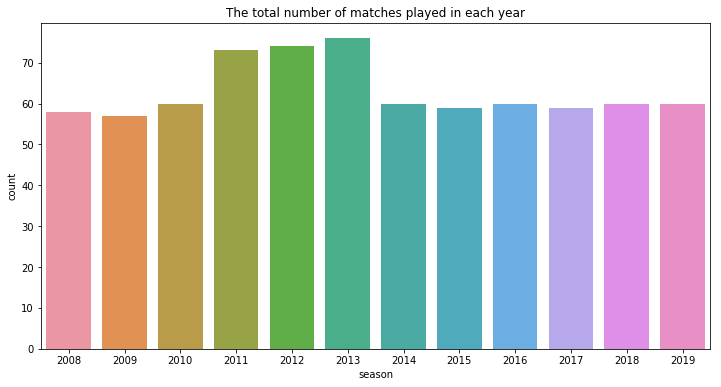

In [11]:
plt.figure(figsize=(12,6))
sns.countplot(x='season', data=matches_df)
plt.title('The total number of matches played in each year')
plt.show()

#### Number of matches in each venue

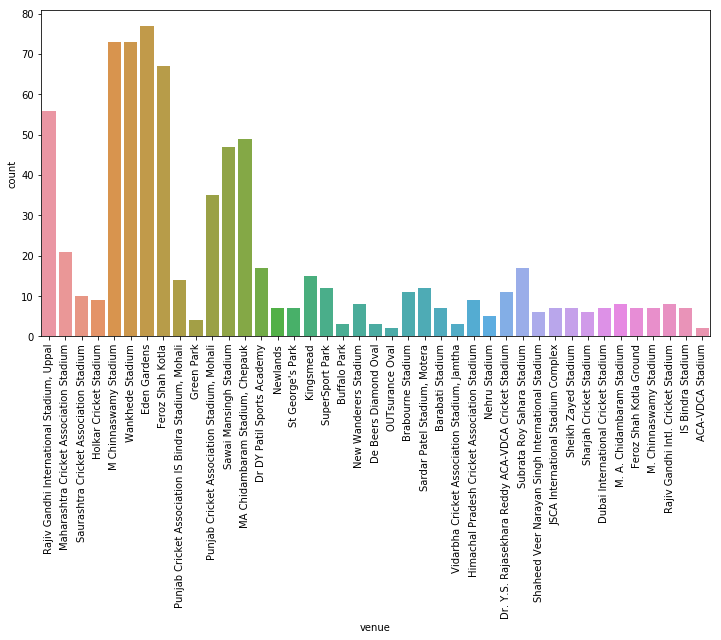

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='venue', data=matches_df)
plt.xticks(rotation='vertical')
plt.show()

Maximum number of matches played at Eden Gardens. This is one of the famous ground in India - where some histroic matches are played

#### Which team played maximum number of matches at Eden Gardens

In [13]:
df = pd.melt(matches_df, id_vars=['id','season'], value_vars=['team1', 'team2'])
df.head()

,id,season,variable,value
0,1,2017,team1,Sunrisers Hyderabad
1,2,2017,team1,Mumbai Indians
2,3,2017,team1,Gujarat Lions
3,4,2017,team1,Rising Pune Supergiant
4,5,2017,team1,Royal Challengers Bangalore


In [14]:
df.columns = ['id', 'season', 'varaible', 'Team']

In [15]:
df.head()

,id,season,varaible,Team
0,1,2017,team1,Sunrisers Hyderabad
1,2,2017,team1,Mumbai Indians
2,3,2017,team1,Gujarat Lions
3,4,2017,team1,Rising Pune Supergiant
4,5,2017,team1,Royal Challengers Bangalore


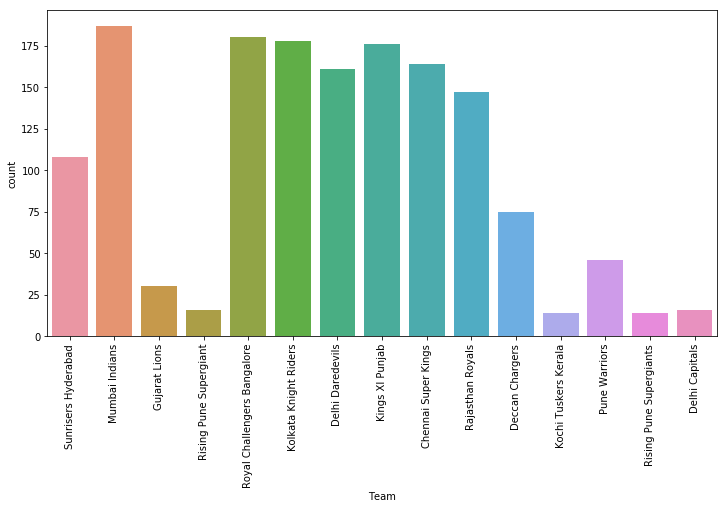

In [16]:
plt.figure(figsize=(12,6))
sns.countplot(x='Team', data=df)
plt.xticks(rotation='vertical')
plt.show()

Seems like Mumbai Indians and Royal challengers Bangalore are the most matches played teams . Deccan chargers and Sunrisers Hyderabad are from the same City - similarly Delhi Daredevils and Delhi Capitals are also representing the same city


In [17]:
eden_df = matches_df[matches_df['venue'] == 'Eden Gardens']

In [18]:
eden_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
10,11,2017,Kolkata,2017-04-13,Kings XI Punjab,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,8,SP Narine,Eden Gardens,A Deshmukh,NJ Llong,NaN
13,14,2017,Kolkata,2017-04-15,Kolkata Knight Riders,Sunrisers Hyderabad,Sunrisers Hyderabad,field,normal,0,Kolkata Knight Riders,17,0,RV Uthappa,Eden Gardens,AY Dandekar,NJ Llong,NaN
22,23,2017,Kolkata,2017-04-21,Kolkata Knight Riders,Gujarat Lions,Gujarat Lions,field,normal,0,Gujarat Lions,0,4,SK Raina,Eden Gardens,CB Gaffaney,Nitin Menon,NaN
26,27,2017,Kolkata,2017-04-23,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,82,0,NM Coulter-Nile,Eden Gardens,CB Gaffaney,CK Nandan,NaN
30,31,2017,Kolkata,2017-04-28,Delhi Daredevils,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,7,G Gambhir,Eden Gardens,NJ Llong,S Ravi,NaN


In [19]:
eden_df_1 = pd.melt(eden_df, id_vars=['id','season'], value_vars=['team1', 'team2'])
eden_df_1.head()

,id,season,variable,value
0,11,2017,team1,Kings XI Punjab
1,14,2017,team1,Kolkata Knight Riders
2,23,2017,team1,Kolkata Knight Riders
3,27,2017,team1,Kolkata Knight Riders
4,31,2017,team1,Delhi Daredevils


In [20]:
eden_df_1.columns = ['id', 'season', 'varaible', 'Team']

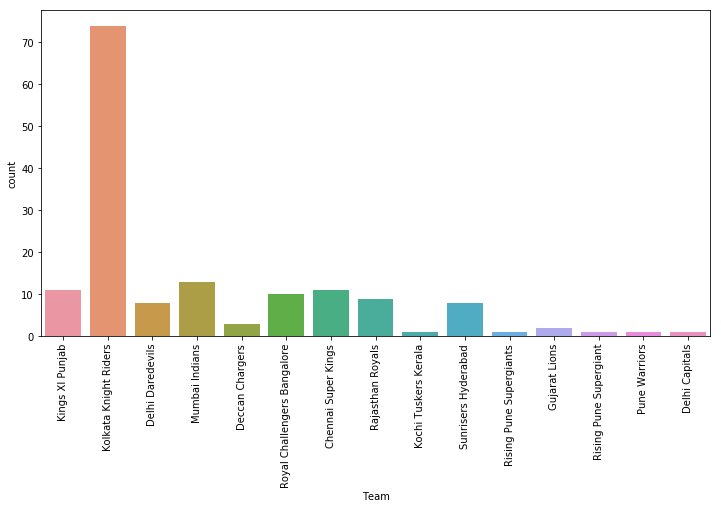

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x='Team', data=eden_df_1)
plt.xticks(rotation='vertical')
plt.show()

#### It seems obvious that Kolkata played lot many matches at Eden gardens - as this is a home ground for Kolkata

### 3.Data Preparation

There are some necessary stpes to apply before continue exploring the dataset:

1) Check for missing values - if available impute them or remove them from analysis

2) There might be some teams with different names - we can club them if required


In [22]:
matches_df.isnull().sum()

id                   0
season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               4
win_by_runs          0
win_by_wickets       0
player_of_match      4
venue                0
umpire1              2
umpire2              2
umpire3            637
dtype: int64

In [23]:
deliveries_df.isnull().sum()

match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
is_super_over            0
wide_runs                0
bye_runs                 0
legbye_runs              0
noball_runs              0
penalty_runs             0
batsman_runs             0
extra_runs               0
total_runs               0
player_dismissed    170244
dismissal_kind      170244
fielder             172630
dtype: int64

Let us remove the columns that have missing values in deliveries dataset

In [24]:
deliveries_df.drop(['player_dismissed', 'dismissal_kind', 'fielder'],axis=1,inplace=True)

##### Convert the date format into weekdays

In [25]:
matches_df['date'] = pd.to_datetime(matches_df['date'])

In [26]:
matches_df["WeekDay"] = matches_df["date"].dt.weekday

In [27]:
matches_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,WeekDay
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,2
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,3
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,4
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,5
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5


### Answer Questions based on dataset

**Q1: What is the win percentage of a team batting second at Wankhede Stadium during 2008 to 2019?**

In [28]:
df = matches_df[(matches_df['toss_decision'] == 'field') &  (matches_df['venue'] == 'Wankhede Stadium') &
             (matches_df['season'] >= 2008) & (matches_df['season'] <= 2019)
             ]

In [29]:
df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,WeekDay
6,7,2017,Mumbai,2017-04-09,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,4,N Rana,Wankhede Stadium,Nitin Menon,CK Nandan,NaN,6
9,10,2017,Mumbai,2017-04-12,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,4,JJ Bumrah,Wankhede Stadium,Nitin Menon,CK Nandan,NaN,2
15,16,2017,Mumbai,2017-04-16,Gujarat Lions,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,6,N Rana,Wankhede Stadium,A Nand Kishore,S Ravi,NaN,6
23,24,2017,Mumbai,2017-04-22,Mumbai Indians,Delhi Daredevils,Delhi Daredevils,field,normal,0,Mumbai Indians,14,0,MJ McClenaghan,Wankhede Stadium,A Nand Kishore,S Ravi,NaN,5
27,28,2017,Mumbai,2017-04-24,Rising Pune Supergiant,Mumbai Indians,Mumbai Indians,field,normal,0,Rising Pune Supergiant,3,0,BA Stokes,Wankhede Stadium,A Nand Kishore,S Ravi,NaN,0


In [30]:
df.shape

(51, 19)

In [31]:
print('The win percentage of a team batting second at Wankhede Stadium during 2008 to 2016 is {}%'.format((df[df['win_by_wickets']>0].shape[0])*100/ df.shape[0]))

The win percentage of a team batting second at Wankhede Stadium during 2008 to 2016 is 50.98039215686274%


In [32]:
df[(df['win_by_wickets']>0)]['winner'].value_counts()

Mumbai Indians                 14
Chennai Super Kings             5
Delhi Daredevils                2
Rajasthan Royals                2
Royal Challengers Bangalore     1
Gujarat Lions                   1
Kochi Tuskers Kerala            1
Name: winner, dtype: int64

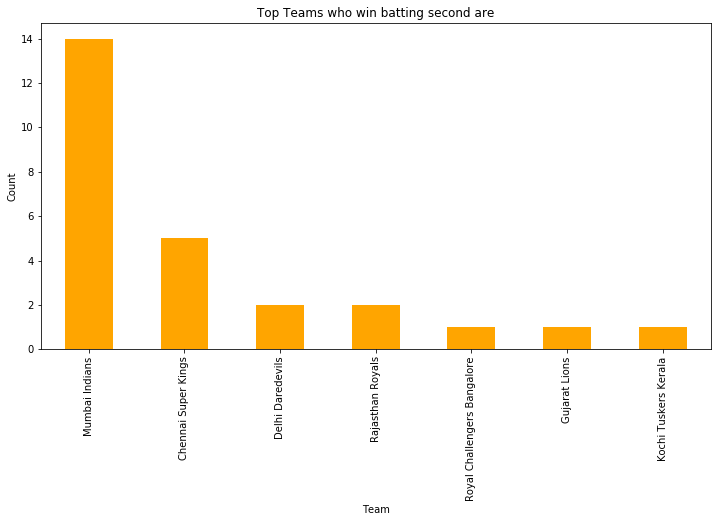

In [33]:
df[df['win_by_wickets']>0]['winner'].value_counts().plot(kind='bar', color='Orange', figsize=(12,6))
plt.xlabel("Team")
plt.ylabel("Count")
plt.title('Top Teams who win batting second are')
plt.show()

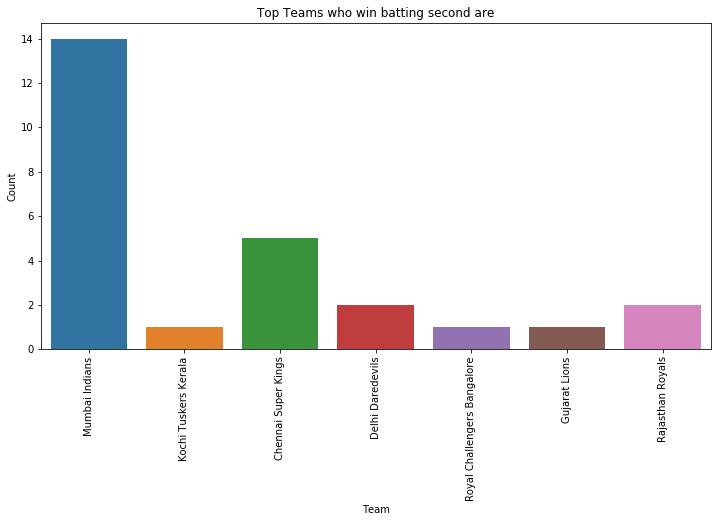

In [34]:
plt.figure(figsize=(12,6))

plt.title('Top Teams who win batting second are')
sns.countplot(x='winner', data=df[df['win_by_wickets']>0])
plt.xlabel("Team")
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

Q2: Which are the weekdays Kolkata Knight Riders wins the most?

In [35]:
df = matches_df[['id', 'WeekDay','winner']]
df = df[df['winner'] == 'Kolkata Knight Riders']

In [36]:
df.head()

,id,WeekDay,winner
2,3,4,Kolkata Knight Riders
10,11,3,Kolkata Knight Riders
13,14,5,Kolkata Knight Riders
17,18,0,Kolkata Knight Riders
26,27,6,Kolkata Knight Riders


Text(0.5, 1.0, 'Kolkata Knight Riders winning on weekdays - where Monday is 0 and Sunday is 6')

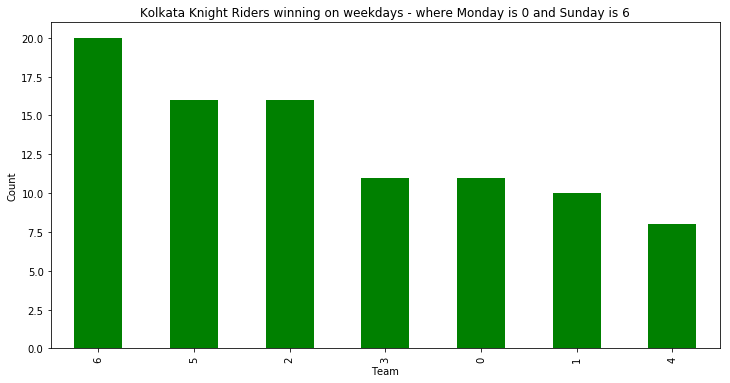

In [37]:
df['WeekDay'].value_counts().plot(kind='bar', color='green', figsize=(12,6))
plt.xlabel("Team")
plt.ylabel("Count")
plt.title('Kolkata Knight Riders winning on weekdays - where Monday is 0 and Sunday is 6')

KKR wins most of the matches on Wednesday(When compared to only weekdays)

**Q3: Which is the best IPL team and how many times it had won in the past? **

Best IPL team can be judged by the number of times it had won. To find which team won in each season - we will first identify the last match played in that year and we assume it should be finals. So Hence collect all the last matches played in each season.

In [38]:
df = matches_df.loc[matches_df.groupby('season').date.idxmax()]

In [39]:
df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,WeekDay
116,117,2008,Mumbai,2008-06-01,Chennai Super Kings,Rajasthan Royals,Rajasthan Royals,field,normal,0,Rajasthan Royals,0,3,YK Pathan,Dr DY Patil Sports Academy,BF Bowden,RE Koertzen,NaN,6
173,174,2009,Johannesburg,2009-05-24,Deccan Chargers,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Deccan Chargers,6,0,A Kumble,New Wanderers Stadium,RE Koertzen,SJA Taufel,NaN,6
233,234,2010,Mumbai,2010-04-25,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Chennai Super Kings,22,0,SK Raina,Dr DY Patil Sports Academy,RE Koertzen,SJA Taufel,NaN,6
306,307,2011,Chennai,2011-05-28,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,bat,normal,0,Chennai Super Kings,58,0,M Vijay,"MA Chidambaram Stadium, Chepauk",Asad Rauf,SJA Taufel,NaN,5
380,381,2012,Chennai,2012-05-27,Chennai Super Kings,Kolkata Knight Riders,Chennai Super Kings,bat,normal,0,Kolkata Knight Riders,0,5,MS Bisla,"MA Chidambaram Stadium, Chepauk",BF Bowden,SJA Taufel,NaN,6


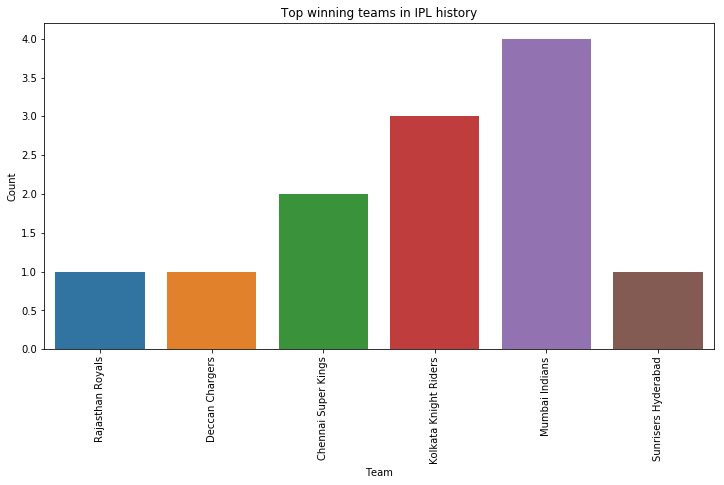

In [40]:
plt.figure(figsize=(12,6))

plt.title('Top winning teams in IPL history')
sns.countplot(x='winner', data=df)
plt.xlabel("Team")
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

Mumbai Indians is the team which won maximum number of times - Hence this is the best team

**Q4:  Predict the winner of the match by just using the matches fields?**

In this analysis, we are going to look at the matches played only during the latest season 2019. So let us subset the dataset to get only these rows.

Also some matches are affected by rain and hence Duckworth-Lewis method are used for these matches and so using these matches for training our model might cause some error in our training and so let us neglect those matches as well.

In [41]:
# Let us take only the matches played in 2019 for this analysis #
matches_df_2019 = matches_df.ix[matches_df.season==2019,:]
matches_df_2019 = matches_df_2019.ix[matches_df_2019.dl_applied == 0,:]
matches_df_2019.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,WeekDay
696,11137,2019,Chennai,2019-03-23,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,7,Harbhajan Singh,M. A. Chidambaram Stadium,Bruce Oxenford,Anil Dandekar,Nitin Menon,5
697,11138,2019,Kolkata,2019-03-24,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,6,AD Russell,Eden Gardens,Chris Gaffaney,Anil Chaudhary,Vineet Kulkarni,6
698,11139,2019,Mumbai,2019-03-24,Delhi Capitals,Mumbai Indians,Mumbai Indians,field,normal,0,Delhi Capitals,37,0,RR Pant,Wankhede Stadium,S Ravi,Yeshwant Barde,O Nandan,6
699,11140,2019,Jaipur,2019-03-25,Kings XI Punjab,Rajasthan Royals,Rajasthan Royals,field,normal,0,Kings XI Punjab,14,0,CH Gayle,Sawai Mansingh Stadium,C Shamshuddin,KN Anantapadmanabhan,Bruce Oxenford,0
700,11141,2019,Delhi,2019-03-26,Delhi Capitals,Chennai Super Kings,Delhi Capitals,bat,normal,0,Chennai Super Kings,0,6,SR Watson,Feroz Shah Kotla Ground,Marais Erasmus,Nitin Menon,Anil Dandekar,1


Okay. Now that we are done with the pre-processing, let us create the variables that are needed for building our model.

I will be considering only the fields from matches dataframe only.

so let us start with these variables and I believe this will be a good starting point. As and when required we can add some more variables.

In [42]:
train_df = matches_df[matches_df['season'] != 2019]

In [43]:
test_df = matches_df[matches_df['season'] == 2019]

In [44]:
train_df.columns

Index(['id', 'season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3', 'WeekDay'],
      dtype='object')

In [45]:
train_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,WeekDay
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,2
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,3
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,4
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,5
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5


In [46]:
train_df = train_df[['city',  'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner',  'venue',
        'WeekDay']]
test_df = test_df[['city',  'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner',  'venue',
        'WeekDay']]

In [47]:
train_df.head()

,city,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,venue,WeekDay
0,Hyderabad,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,"Rajiv Gandhi International Stadium, Uppal",2
1,Pune,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,Maharashtra Cricket Association Stadium,3
2,Rajkot,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,Saurashtra Cricket Association Stadium,4
3,Indore,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,Holkar Cricket Stadium,5
4,Bangalore,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,M Chinnaswamy Stadium,5


In [48]:
train_df.isnull().sum()

city             7
team1            0
team2            0
toss_winner      0
toss_decision    0
result           0
dl_applied       0
winner           3
venue            0
WeekDay          0
dtype: int64

In [49]:
test_df.isnull().sum()

city             0
team1            0
team2            0
toss_winner      0
toss_decision    0
result           0
dl_applied       0
winner           1
venue            0
WeekDay          0
dtype: int64

In [50]:
train_df= train_df.dropna()
test_df = test_df.dropna()

In [51]:
train_df.head()

,city,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,venue,WeekDay
0,Hyderabad,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,"Rajiv Gandhi International Stadium, Uppal",2
1,Pune,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,Maharashtra Cricket Association Stadium,3
2,Rajkot,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,Saurashtra Cricket Association Stadium,4
3,Indore,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,Holkar Cricket Stadium,5
4,Bangalore,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,M Chinnaswamy Stadium,5


In [52]:
train_df.dtypes

city             object
team1            object
team2            object
toss_winner      object
toss_decision    object
result           object
dl_applied        int64
winner           object
venue            object
WeekDay           int64
dtype: object

In [53]:
test_df.dtypes

city             object
team1            object
team2            object
toss_winner      object
toss_decision    object
result           object
dl_applied        int64
winner           object
venue            object
WeekDay           int64
dtype: object

In [54]:
# Importing LabelEncoder and initializing it
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
# Iterating over all the common columns in train and test
for col in train_df.columns.values:
    # Encoding only categorical variables
    if train_df[col].dtypes=='object':
        print(col)
        # Using whole data to form an exhaustive list of levels
        data=train_df[col].append(test_df[col])
        le.fit(data.values) 
        train_df[col]=le.transform(train_df[col])
        test_df[col]=le.transform(test_df[col])

city
team1
team2
toss_winner
toss_decision
result
winner
venue


In [55]:
X = train_df.drop(['winner'],axis=1)
y = train_df['winner']

train_X = X
train_y = y

test_X = test_df.drop(['winner'],axis=1)
y_test = test_df['winner']

### 4.Modelling

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Split into training and test sets
X_train, X_valid , y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

from sklearn import metrics
model = LogisticRegression()
model.fit(X_train,y_train)
prediction=model.predict(X_valid)
print('The accuracy of the Logistic Regression is', metrics.accuracy_score(prediction,y_valid))

The accuracy of the Logistic Regression is 0.3300970873786408


In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)
y_valid_preds = rf.predict(X_valid)
print("The validation accuracy score is", metrics.accuracy_score(y_valid, y_valid_preds))

print("The test accuarcy score is", metrics.accuracy_score(y_test, rf.predict(test_X)))

The validation accuracy score is 0.5436893203883495
The test accuarcy score is 0.5254237288135594


We are able to predict with a good start point accuracy with the randomforest model - but here we need to identify which of the features are important to predict the outcome. For this let us look at the feature importance.

In [58]:
coefs_df = pd.DataFrame()

coefs_df['Features'] = X_train.columns
coefs_df['Coefs'] = rf.feature_importances_
coefs_df.sort_values('Coefs', ascending=False).head(10)

,Features,Coefs
2,team2,0.203345
1,team1,0.185534
3,toss_winner,0.150736
7,venue,0.145241
8,WeekDay,0.144066
0,city,0.132293
4,toss_decision,0.028877
6,dl_applied,0.008043
5,result,0.001865


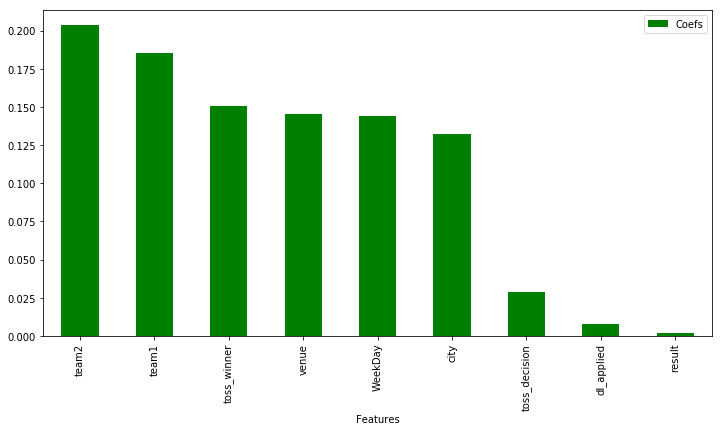

In [59]:
coefs_df.set_index('Features', inplace=True)
coefs_df.sort_values('Coefs', ascending=False).head(10).plot(kind='bar', color='green', figsize=(12,6))

From the above important features - if we ignore team2 and team1, the important features are toss_winner and venue.

So can we assume that if a team wins the toss - is it going to win the match? Let us look at descriptive statistics of the team winning toss and winning the match combination

In [60]:
def check_winner(a,b):
    if (a == b):
        return 1
    else:
        return 0

train_df['win_toss_win_match'] = train_df.apply(lambda row: check_winner(row['toss_winner'],row['winner']),axis=1)


In [61]:
train_df.head()

,city,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,venue,WeekDay,win_toss_win_match
0,14,14,13,13,1,0,0,14,27,2,0
1,26,8,11,11,1,0,0,11,20,3,1
2,28,4,7,7,1,0,0,7,30,4,1
3,15,11,5,5,1,0,0,5,12,5,1
4,2,13,3,13,0,0,0,13,16,5,1


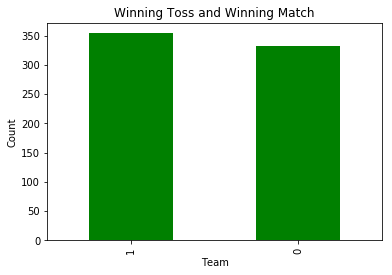

In [62]:
train_df['win_toss_win_match'].value_counts().plot(kind='bar', color='green')

plt.title('Winning Toss and Winning Match')
plt.xlabel("Team")
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

Clearly from the above plot - we can see that if a team wins toss and wins match combination is high. Hence we proved the same from our model output accuracy.

Here by just using the matches dataset fields we are able to predict the match outcome with a decent accuracy. We can build a robust model by applying more features from the deliveries dataset.